# Описание

## Цель

Построение решающего дерева.  
Сравнение решающего дерева, бэггинга и случайного леса на различных наборах данных.

## Задачи

1. Решающие деревья.
* Критерий Джини и Энтропия.
* Построение дерева своими руками.
2. Сравнение решающего дерева, бэггинга, случайного леса.

## 1. Решающие деревья.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from collections import Counter
from typing import Dict, List, Tuple, Union
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import LabelEncoder

**Напоминание об энтропии.**  
Пусть в вершину решающего дерева попало 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Расcчитаем энтропию такого распределения, округлив до 2 знаков после запятой.

Формула:
$$
H(p_1, ..., p_k) = -\sum_{i=1}^{K}p_i \cdot log_2(p_i)
$$
Это классическая формула энтропии, мы можем заменить ее на формулу с натуральным логарифмом, так как логарифм монотонно убывающая функция, это просто проскалирует исходное H.

In [ ]:
np.round(- (8/10 * np.log2(8/10) + 2/10 * np.log2(2/10)), 2)

0.72

**Напоминание о критерии информативности и критерии Джини.**  
Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитаем критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлим до 2 знаков после запятой.

Подсчитаем индекс Джини для вершины:

$$
H(R_m) = 2 \cdot \frac{8}{10} \cdot \frac{2}{10} = 0.32
$$

Индексы Джини для левого и правого поддерева равны 0, поскольку там находятся объекты одного класса

Тогда критерий информативности:
$$
Q = H(R_m) = 0.32
$$

**Напоминание о предсказаниях деревьев для задачи регрессии.**  
Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

Так как это **листовая вершина** для **задачи регрессии**, то ответ получается по формуле:
$$
y = \frac{1}{10} \cdot [1 + 10 + ... + 47] = 40.6
$$

In [ ]:
sns.set_theme()

Реализуем функцию `find_best_split()`, которая будет находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием, упомянутым выше. В качестве меры хаотичности $H(R)$ для задачи регрессии будем использовать дисперсию подвыборки, а для задачи классификации – критерий Джини.

Для категориальных признаков будем применять наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. На самом деле, это далеко не оптимальный способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.array(feature_vector)
    if feature_type == "real":
        feature_unique = np.sort(np.unique(feature_vector))
        thresholds = (feature_unique[1:] + feature_unique[:-1]) / 2
        IG = [0] * len(thresholds)
        for i in range(len(thresholds)):
            thr = thresholds[i]
            left = target_vector[feature_vector <= thr]
            right = target_vector[feature_vector > thr]
            gini_main = gini_impurity(target_vector, task)
            gini_left = gini_impurity(left, task)
            gini_right = gini_impurity(right, task)
            IG[i] = gini_main - (len(left) * gini_left + len(right) * gini_right) / len(target_vector)

        IG = np.array(IG)
        best_ind = np.argmax(IG)
        thresholds_best = thresholds[best_ind]
        gini_best = IG[best_ind]
        return thresholds, IG, thresholds_best, gini_best
    elif feature_type == "categorical":
        thresholds = np.unique(feature_vector)
        IG = [0] * len(thresholds)
        for i in range(len(thresholds)):
            thr = thresholds[i]
            left = target_vector[feature_vector == thr]
            right = target_vector[feature_vector != thr]
            gini_main = gini_impurity(target_vector, task)
            gini_left = gini_impurity(left, task)
            gini_right = gini_impurity(right, task)
            IG[i] = gini_main - (len(left) * gini_left + len(right) * gini_right) / len(target_vector)

        IG = np.array(IG)
        best_ind = np.argmax(IG)
        thresholds_best = thresholds[best_ind]
        gini_best = IG[best_ind]
        return thresholds, IG, thresholds_best, gini_best

def gini_impurity(y, task):
    if task == "classification":
        _, counts = np.unique(y, return_counts = True)
        probabilities = counts / len(y)
        return 1 - np.sum(probabilities ** 2)
    else:
        return np.mean((y - np.mean(y)) ** 2)

Протестируем эту функцию на датасете `California`.

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Выведем график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
feature_vector, target_vector = X['MedInc'], y
thresholds, IG, threshold_best, IG_best = find_best_split(feature_vector, target_vector, 'regression', 'real')

Best criterion: 0.41275138620167695


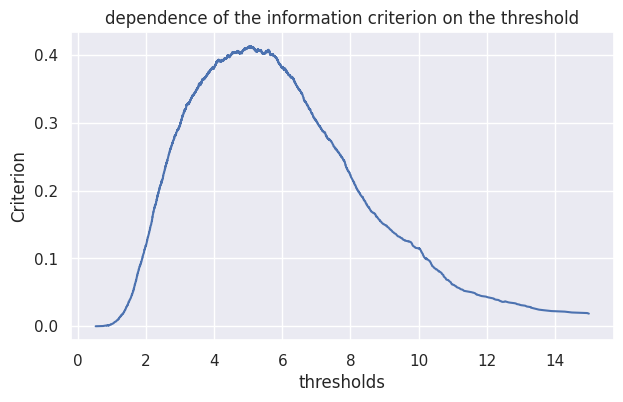

In [ ]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.lineplot(x = thresholds, y = IG, ax = ax)
ax.set_xlabel("thresholds")
ax.set_ylabel("Criterion")
ax.set_title("dependence of the information criterion on the threshold")

print("Best criterion: {}".format(IG_best))
plt.show()

### Построение дерева своими руками.

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

Построение дерева будем осуществлять согласно базовому жадному алгоритму.
- **Выбор лучшего разбиения** будем производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    left_split = feature_vector <= threshold_best
                    right_split = feature_vector > threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    left_split = feature_vector == threshold_best
                    right_split = feature_vector != threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[left_split], sub_y[left_split], node["left_child"])
        self._fit_node(sub_X[right_split], sub_y[right_split], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        now_node = node
        while now_node["type"] == "nonterminal":
            if "threshold" in now_node:
                thr = now_node["threshold"]
                feature = now_node["feature_split"]
                if x[feature] <= thr:
                    now_node = now_node["left_child"]
                else:
                    now_node = now_node["right_child"]
            elif "category_split" in now_node:
                thr = now_node["category_split"]
                feature = now_node["feature_split"]
                if x[feature] == thr:
                    now_node = now_node["left_child"]
                else:
                    now_node = now_node["right_child"]

        return now_node["class"]


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

Загрузим таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Построим на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируем диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [ ]:
df = pd.read_csv("students.csv", index_col = 0)
df.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [ ]:
X, y = df.iloc[:, :5], df["UNS"]
X.head()

,STG,SCG,STR,LPR,PEG
0,0.00,0.00,0.00,0.00,0.00
1,0.08,0.08,0.10,0.24,0.90
2,0.06,0.06,0.05,0.25,0.33
3,0.10,0.10,0.15,0.65,0.30
4,0.08,0.08,0.08,0.98,0.24


In [ ]:
def visualise_gini(X: pd.DataFrame, y: np.ndarray):
    fig, ax = plt.subplots(figsize = (10, 6))

    for i, column_name in enumerate(X):
        column_data = X[column_name]
        thresholds, IG, threshold_best, gini_best = find_best_split(column_data, y, "classification", "real")
        sns.lineplot(x = thresholds, y = IG, ax = ax, label = column_name)

    ax.set_xlabel("thresholds")
    ax.set_ylabel("IG")
    ax.set_title("Dependence IG from thresholds for each feature")
    ax.legend()


    plt.show()

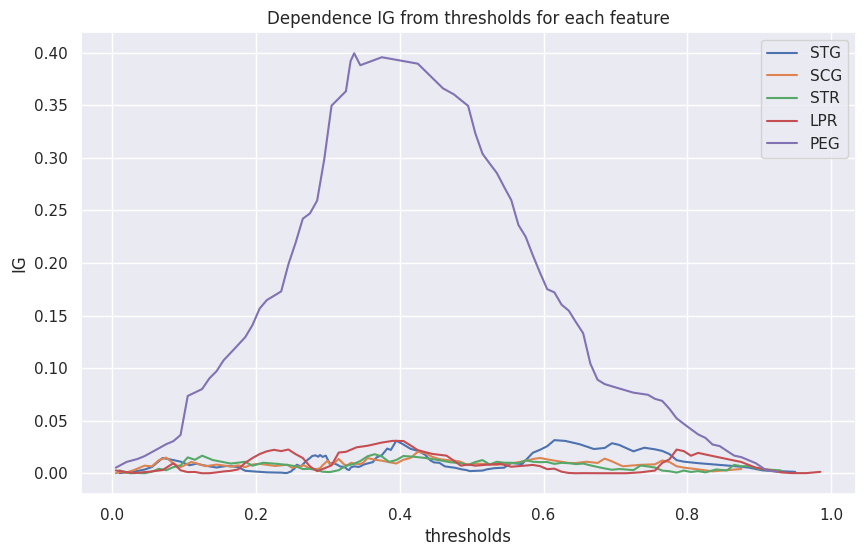

In [ ]:
visualise_gini(X, y)

In [ ]:
def visualise_scatter(X: pd.DataFrame, y: np.ndarray):
    fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize = (12, 10))

    for i, column_name in enumerate(X):
        column_data = X[column_name].values
        zero_ind, = np.where(y == 0)
        one_ind, = np.where(y == 1)
        ax[i].scatter(column_data[zero_ind], y[zero_ind], color = 'b', alpha = 0.5, label = 'negative_class')
        ax[i].scatter(column_data[one_ind], y[one_ind], color = 'r', alpha = 0.5, label = 'positive_class')
        ax[i].set_title(column_name)
        ax[i].set_title("{} data".format(column_name))
        ax[i].legend()
        ax[i].set_xlim(-0.12, 1.12)
        ax[i].set_ylim(-0.12, 1.12)

    fig.suptitle("Distribution by classes over each column")
    plt.tight_layout()
    plt.show()

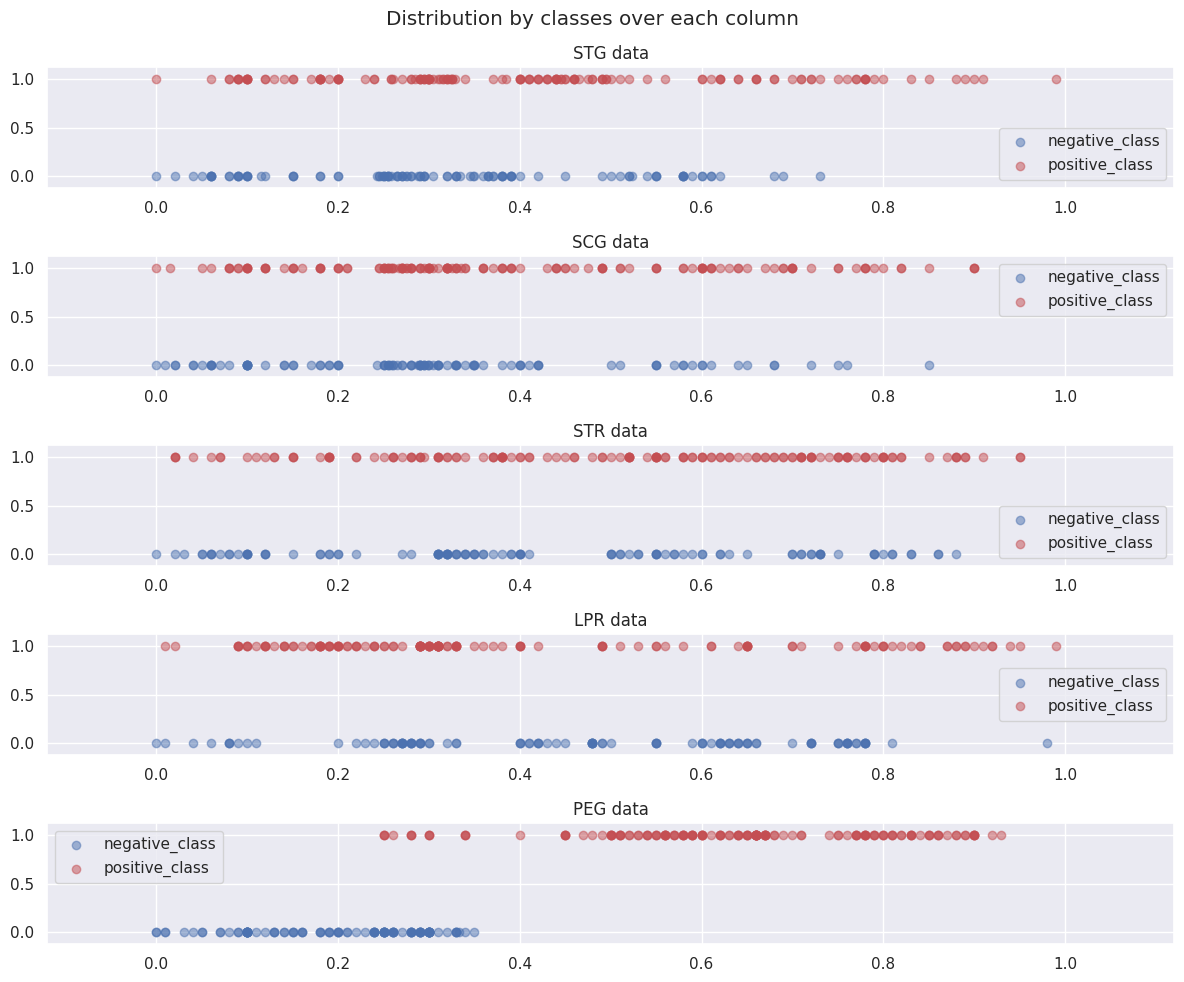

In [ ]:
visualise_scatter(X, y)

Исходя из кривых значений критерия Джини, нужно производить деление выборки на два поддерева по PEG колонке, поскольку там индекс Джини максимален.  
Это согласуется с визуальной оценкой диаграмм рассеяния, поскольку в PEG данные можно разделить с наибольшим критерием. Явно видно, что при PEG > 0.5 большинство объектов отнесены к положительному классу.  
По остальным столбцам пороги будут не настолько выгодны, поскольку нет такого явного преимущества одного threshold над другим.

Протестируем свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачаем таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считаем таблицу при помощи `pandas`,
3. Применим к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучим решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделаем предсказания для оставшейся половины. Вычислим accuracy.

In [ ]:
df = pd.read_csv("agaricus-lepiota.data")
df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


Все переменные категориальные, будем кодировать с помощью `LabelEncoder`.

In [ ]:
le = LabelEncoder()

In [ ]:
for col in df:
    df[col] = le.fit_transform(df[col])
df.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


Здесь в первом столбце:  
0 соответствует `edible`, 1 соответствует `poisonous`.



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = "p"),
                                                    df["p"],
                                                    test_size = 0.5,
                                                    random_state = 13)

In [ ]:
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [ ]:
dt = DecisionTree(["categorical"] * X_train.shape[1], task = "classification")

In [ ]:
dt.fit(X_train, y_train)
dt._tree

{'type': 'nonterminal',
 'feature_split': 4,
 'category_split': 5,
 'left_child': {'type': 'nonterminal',
  'feature_split': 19,
  'category_split': 5,
  'left_child': {'type': 'terminal', 'class': 1},
  'right_child': {'type': 'nonterminal',
   'feature_split': 2,
   'category_split': 9,
   'left_child': {'type': 'terminal', 'class': 1},
   'right_child': {'type': 'nonterminal',
    'feature_split': 14,
    'category_split': 8,
    'left_child': {'type': 'terminal', 'class': 1},
    'right_child': {'type': 'nonterminal',
     'feature_split': 0,
     'category_split': 1,
     'left_child': {'type': 'terminal', 'class': 1},
     'right_child': {'type': 'nonterminal',
      'feature_split': 1,
      'category_split': 1,
      'left_child': {'type': 'terminal', 'class': 1},
      'right_child': {'type': 'terminal', 'class': 0}}}}}},
 'right_child': {'type': 'nonterminal',
  'feature_split': 10,
  'category_split': 2,
  'left_child': {'type': 'nonterminal',
   'feature_split': 3,
   'cate

In [ ]:
y_pred = dt.predict(X_test)
accuracy_score(y_pred, y_test)

0.9972919743968488

## Сравнение бэггинга, случайного леса и бустинга

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Приведем все колонки к нижнему индексу

In [ ]:
data = data.rename(columns = lambda col: col.lower())
data.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

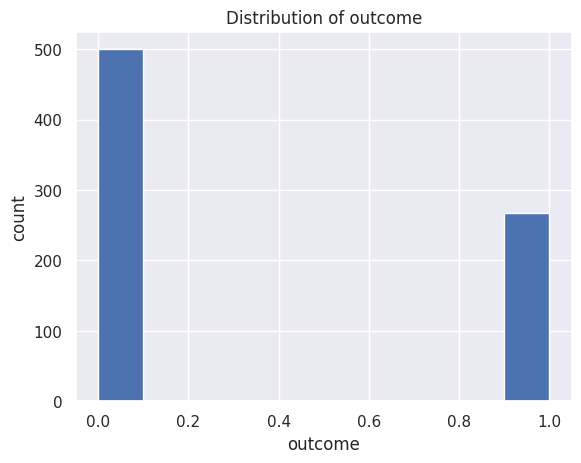

In [ ]:
data['outcome'].hist()
plt.xlabel('outcome')
plt.ylabel('count')
plt.title('Distribution of outcome')
plt.show()

Целевая переменная распределена неравномерно.

Разделим данные на признаки и целевую переменную. Разобьем датасет на обучающую и тестовую части в отношении 7:3. Затем разделим обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге получается три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X, X_test, y, y_test = train_test_split(data.drop(columns = 'outcome'),
                                        data['outcome'],
                                        test_size = 0.3,
                                        shuffle = False,
                                        random_state = 13)
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      test_size = 0.3,
                                                      shuffle = True,
                                                      random_state = 13)

На обучающей-валидационной выборке подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создадим списки с возможными значениями для перебора.
2. Для каждой пары значений обучим дерево на обучающей-обучающей выборке и определим качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберем ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучим решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оценим качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
def get_results(y_pred, y_true):

    # Подсчитываем метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted') # поскольку классы не сбалансированы
    recall = recall_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_pred)

    return [accuracy, precision, recall, roc_auc]

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 5, scoring = 'f1', verbose = 1)
grid_search.fit(X_train, y_train)

print("Best Params: {}".format(grid_search.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'max_depth': 7, 'min_samples_leaf': 5}


In [ ]:
dt = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 5)
dt.fit(X, y)

# Получим предсказания модели
y_pred = dt.predict(X_test)
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'ROC-AUC']
}

df = pd.DataFrame(metrics)
df['Score_bt'] = get_results(y_pred, y_test)
df

,Metric,Score_bt
0,Accuracy,0.740260
1,Precision,0.731739
2,Recall,0.740260
3,ROC-AUC,0.687125


Обучим [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оценим качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
bc = BaggingClassifier(estimator = DecisionTreeClassifier(), n_estimators = 50)
bc.fit(X, y)

# Получим предсказания модели
y_pred = bc.predict(X_test)

df['Score_bc'] = get_results(y_pred, y_test)
df

,Metric,Score_bt,Score_bc
0,Accuracy,0.740260,0.800866
1,Precision,0.731739,0.797055
2,Recall,0.740260,0.800866
3,ROC-AUC,0.687125,0.763574


Видим серьезное улучшение качества

Выполним кросс-валидацию на полной обучающей выборке и подберем оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создадим списки с возможными значениями для перебора.
2. Для каждой пары значений проведем кросс-валидацию на полной обучающей выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберем ту пару значений, которая даёт наилучшее среднее качество.

Обучим случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оценим качество классификации по тем же метрикам.

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 20, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators = 50), param_grid, cv = 5, scoring = 'f1', verbose = 2)
grid_search.fit(X_train, y_train)

print("Best Params: {}".format(grid_search.best_params_))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ....................max_depth=3, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=1; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=2; total time=   0.1s
[CV] END ....................max_depth=3, min_samples_leaf=3; total time=   0.1s
[CV] END ....................max_depth=3, min_s

In [ ]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 30, min_samples_leaf = 4)
rf.fit(X, y)

y_pred = rf.predict(X_test)
df['Score_rf'] = get_results(y_pred, y_test)
df

,Metric,Score_bt,Score_bc,Score_rf
0,Accuracy,0.740260,0.800866,0.796537
1,Precision,0.731739,0.797055,0.793218
2,Recall,0.740260,0.800866,0.796537
3,ROC-AUC,0.687125,0.763574,0.745087


BaggingClassifier и RandomForestClassifier показывают себя примерно одинаково.  
Если повторять процедуру обучения несколько раз, то иногда лучше себя показывает Bagging, иногда RandomForest.

Построим график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке.

In [ ]:
estimators = [2 * i for i in range(1, 100)]
roc_auc = []
for n_estimators in estimators:
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(X, y)

    y_pred = model.predict(X_test)
    roc_auc.append(roc_auc_score(y_test, y_pred))

Train Shape: (375, 8)


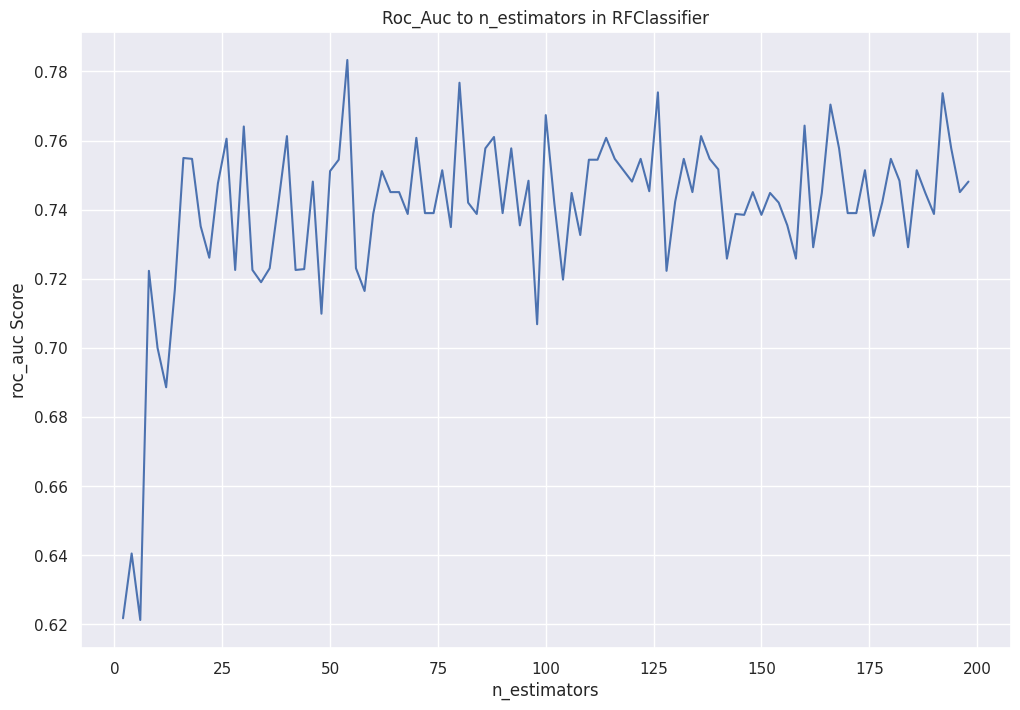

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.lineplot(x = estimators, y = roc_auc, ax = ax)

ax.set_xlabel("n_estimators")
ax.set_ylabel("roc_auc Score")
ax.set_title("Roc_Auc to n_estimators in RFClassifier")

print("Train Shape: {}".format(X_train.shape))
plt.show()

В среднем мы можем видеть улучшение качества модели при увеличении `n_estimators`, как и говорил создатель `RF`.   
Рваный график связан с размером тренировочной выборки, который очень мал. (Всего лишь 378 элементов)

Для лучшей модели случайного леса из **Задания 3.4** посчитаем важность признаков и построим bar plot.

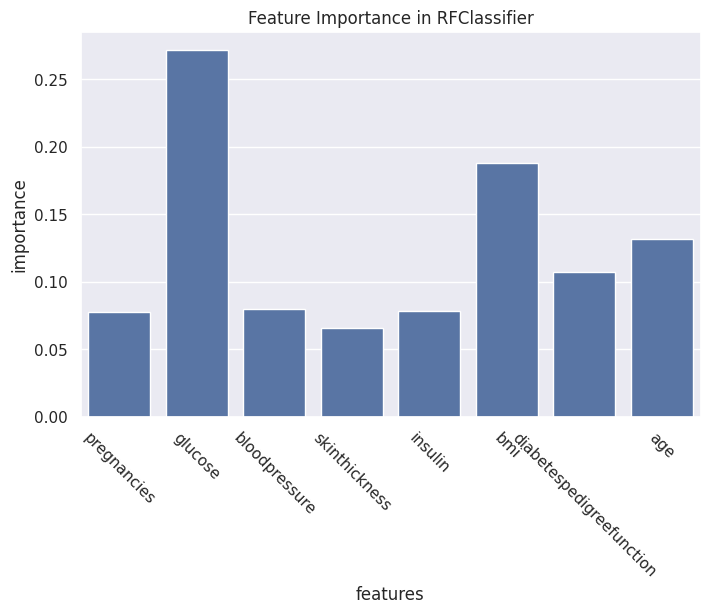

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
sns.barplot(x = X.columns, y = rf.feature_importances_, ax = ax)

ax.set_xlabel("features")
ax.set_ylabel("importance")
ax.set_title("Feature Importance in RFClassifier")
ax.tick_params(axis='x', rotation=-45)

plt.show()

Уровень глюкозы оказался самым важным для определения диабета